In [1]:
from pathlib import Path
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage.io

sys.path.insert(0,'..')

In [2]:
list(Path('../data/external/tcga/').rglob('*.tiff'))

[PosixPath('../data/external/tcga/TCGA-HC-A6AS-01Z-00-DX1.1E5AB965-7B24-4C19-BFEA-91FF7D08DD1D.tiff'),
 PosixPath('../data/external/tcga/TCGA-HC-A6AP-01Z-00-DX1.1E2C19B4-6757-488D-AFB4-71AE5FD6EC11.tiff'),
 PosixPath('../data/external/tcga/TCGA-HC-A6HY-01Z-00-DX1.9753A5EC-6068-4502-ACBB-4C6F1EA77AF9.tiff'),
 PosixPath('../data/external/tcga/TCGA-EJ-5526-01Z-00-DX1.70486c91-c1cd-4478-8c90-b103dacda0ae.tiff'),
 PosixPath('../data/external/tcga/TCGA-KK-A7AZ-01Z-00-DX1.88A60F6F-7BB9-40AC-B5FE-0BCE88B30ADA.tiff'),
 PosixPath('../data/external/tcga/TCGA-HC-A632-01Z-00-DX1.4F297280-B867-4109-822F-CD0DD4A699EE.tiff'),
 PosixPath('../data/external/tcga/TCGA-HC-7740-01Z-00-DX1.e0d2817f-fe41-4d04-a164-68f601a4e82e.tiff'),
 PosixPath('../data/external/tcga/TCGA-VP-A879-01Z-00-DX1.FC957319-7D9E-4480-B279-D42D5FFD2A4B.tiff'),
 PosixPath('../data/external/tcga/TCGA-J4-AAU2-01Z-00-DX1.856D1A98-E6A7-499C-9645-E598523C10CB.tiff'),
 PosixPath('../data/external/tcga/TCGA-4L-AA1F-01Z-00-DX1.D793A68B-6E98-4

In [26]:
tcga_csv = pd.read_csv('../data/tcga.csv')
print("number of elements before filtering:", len(tcga_csv))
tcga_csv = tcga_csv[tcga_csv['gleason_score'] != 'None']
print("number of elements after filtering:", len(tcga_csv))

tcga = list(Path('../data/external/tcga/').rglob('*.tiff'))

tcga_paths = [str(x) for x in tcga]
tcga_ids = ['-'.join(x.stem.split('-')[0:3]) for x in tcga]

tcga_df = pd.DataFrame({'paths': tcga_paths, 'image_id': tcga_ids})


number of elements before filtering: 1000
number of elements after filtering: 500


In [5]:
display(tcga_df.sort_values(by=['image_id']))
display(tcga_csv.sort_values(by=['image_id']))

,paths,image_id
396,../data/external/tcga/TCGA-2A-A8VL-01Z-00-DX1....,TCGA-2A-A8VL
388,../data/external/tcga/TCGA-2A-A8VO-01Z-00-DX1....,TCGA-2A-A8VO
64,../data/external/tcga/TCGA-2A-A8VT-01Z-00-DX1....,TCGA-2A-A8VT
39,../data/external/tcga/TCGA-2A-A8VV-01Z-00-DX1....,TCGA-2A-A8VV
423,../data/external/tcga/TCGA-2A-A8VX-01Z-00-DX1....,TCGA-2A-A8VX
...,...,...
389,../data/external/tcga/TCGA-YL-A9WJ-01Z-00-DX1....,TCGA-YL-A9WJ
433,../data/external/tcga/TCGA-YL-A9WK-01Z-00-DX1....,TCGA-YL-A9WK
239,../data/external/tcga/TCGA-YL-A9WL-01Z-00-DX1....,TCGA-YL-A9WL
276,../data/external/tcga/TCGA-YL-A9WX-01Z-00-DX1....,TCGA-YL-A9WX


,image_id,gleason_score,isup_grade,data_provider
122,TCGA-2A-A8VL,3+3,1,tcga
278,TCGA-2A-A8VO,3+3,1,tcga
876,TCGA-2A-A8VT,4+5,5,tcga
114,TCGA-2A-A8VV,3+3,1,tcga
829,TCGA-2A-A8VX,4+4,4,tcga
...,...,...,...,...
856,TCGA-ZG-A9M4,5+4,5,tcga
621,TCGA-ZG-A9MC,5+4,5,tcga
784,TCGA-ZG-A9N3,5+4,5,tcga
217,TCGA-ZG-A9ND,5+4,5,tcga


In [28]:
merged_df = tcga_df.merge(tcga_csv, on='image_id')

In [29]:
merged_df['isup_grade'].value_counts()

2       123
5       101
3        89
4        50
1        39
None      1
Name: isup_grade, dtype: int64

In [7]:
merged_df['isup_grade'].value_counts()

2       126
5       122
3        92
4        65
1        43
None      1
Name: isup_grade, dtype: int64

In [8]:
img_large = skimage.io.MultiImage('../data/external/tcga/TCGA-XQ-A8TA-01Z-00-DX1.D1346DCD-E0CC-4914-967E-49B4E901836C.tiff')
img_small = skimage.io.MultiImage('../data/external/tcga/TCGA-HC-A6HY-01Z-00-DX1.9753A5EC-6068-4502-ACBB-4C6F1EA77AF9.tiff')

/vol/tensusers2/sdooper/Anaconda3/envs/panda/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:3051: UserWarning: incorrect count for tag 'reference_black_white'
  warnings.warn("incorrect count for tag '%s'" % name)


In [9]:
for i,level in enumerate(img_large):
    print(f"Biopsy level {i} dimensions: {level.shape}")
    print(f"Biopsy level {i} memory size: {level.nbytes / 1024**2:.1f}mb")
    
for i,level in enumerate(img_small):
    print(f"Biopsy level {i} dimensions: {level.shape}")
    print(f"Biopsy level {i} memory size: {level.nbytes / 1024**2:.1f}mb")    

Biopsy level 0 dimensions: (22505, 49302, 3)
Biopsy level 0 memory size: 3174.4mb
Biopsy level 1 dimensions: (11252, 24651, 3)
Biopsy level 1 memory size: 793.6mb
Biopsy level 2 dimensions: (5626, 12325, 3)
Biopsy level 2 memory size: 198.4mb
Biopsy level 3 dimensions: (2813, 6162, 3)
Biopsy level 3 memory size: 49.6mb
Biopsy level 4 dimensions: (1406, 3081, 3)
Biopsy level 4 memory size: 12.4mb
Biopsy level 5 dimensions: (703, 1540, 3)
Biopsy level 5 memory size: 3.1mb
Biopsy level 6 dimensions: (351, 770, 3)
Biopsy level 6 memory size: 0.8mb
Biopsy level 7 dimensions: (175, 385, 3)
Biopsy level 7 memory size: 0.2mb
Biopsy level 8 dimensions: (87, 192, 3)
Biopsy level 8 memory size: 0.0mb
Biopsy level 9 dimensions: (43, 96, 3)
Biopsy level 9 memory size: 0.0mb
Biopsy level 0 dimensions: (4705, 4796, 3)
Biopsy level 0 memory size: 64.6mb
Biopsy level 1 dimensions: (2352, 2398, 3)
Biopsy level 1 memory size: 16.1mb
Biopsy level 2 dimensions: (1176, 1199, 3)
Biopsy level 2 memory size: 4

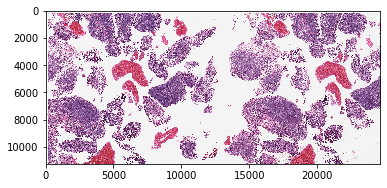

In [57]:
plt.figure()
plt.imshow(img_large[1])

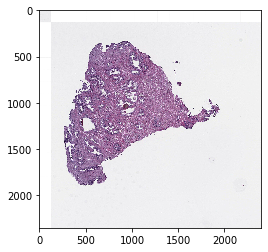

In [58]:
plt.figure()
plt.imshow(img_small[1])